# SDH Conference Paper Test Case 1

This tutorial shows how to let modesto solve a simple network.

# Imports and other stuff

In [1]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

plt.style.use('classic')

In [2]:
%matplotlib notebook

In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('SDH')

# Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes (besides the name of the node):
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges (besides names of the nodes where the edge starts and stops):
* **Name of the edge**
    

In [4]:
G = nx.DiGraph()

G.add_node('SolarArray', x=0, y=5000, z=0,
           comps={'solar': 'SolarThermalCollector',
                  'tank': 'StorageVariable'
                 })

G.add_node('WaterscheiGarden', x=0, y=0,  z=0,
           comps={'neighb': 'BuildingFixed',
                  'tank': 'StorageVariable'})

G.add_node('p1', x=1000, y=2400, z=0, comps={})

G.add_node('p2', x=4000, y=2800, z=0, comps={})

G.add_node('TermienWest', x=4200, z=0, y=4600, 
           comps={'neighb': 'BuildingFixed',
                  'tank': 'StorageVariable'})

G.add_node('Production', x=6000, y=4000, z=0, comps={'backup': 'ProducerVariable'})
G.add_node('TermienEast', x=5400, y=200, z=0, comps={'neighb': 'BuildingFixed'})

In [5]:
G.add_edge('SolarArray', 'p1', name='servSol')
G.add_edge('p1', 'WaterscheiGarden', name='servWat')
G.add_edge('p1', 'p2', name='backBone')
G.add_edge('p2', 'TermienWest', name='servTer')
G.add_edge('p2', 'TermienEast', name='servBox')
G.add_edge('Production', 'p2', name='servPro')

<IPython.core.display.Javascript object>


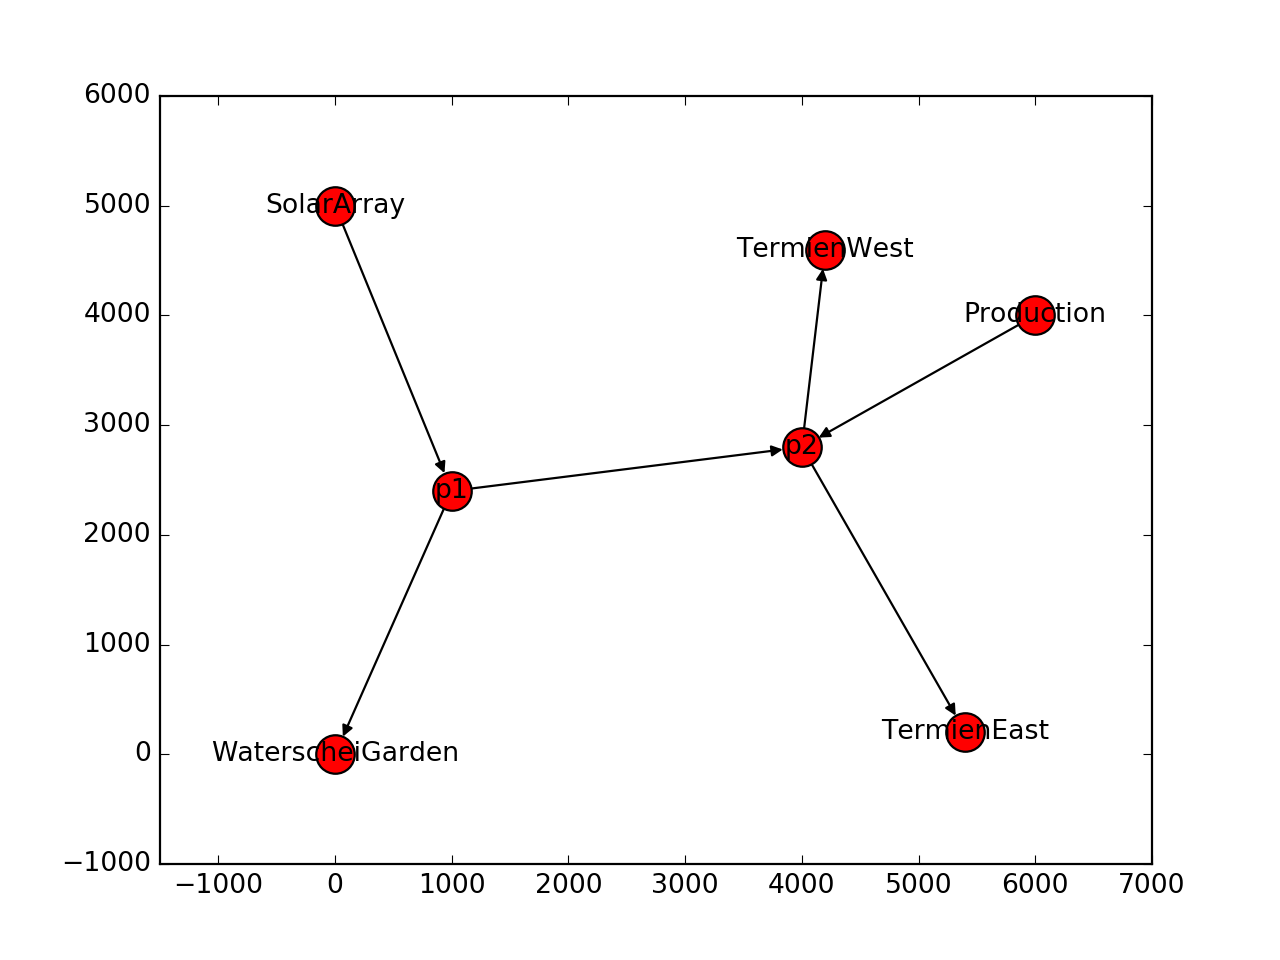

In [6]:
pos = {}
for node in G:
    #print node
    pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

fig, ax = plt.subplots()
nx.draw_networkx(G, with_labels=True,  pos=pos, ax=ax)
ax.set_xlim(-1500, 7000)
fig.savefig('img/NetworkLayout.svg')#, dpi=150)

# Setting up modesto

Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types). Possibilities: SimplePipe (= perfect pipe, no losses, no time delays), ExtensivePipe (limited mass flows and heat losses, no time delays) and NodeMethod (heat losses and time delays, but requires mass flow rates to be known in advance)

In [7]:
horizon = 365*24*3600
time_step = 6*3600
start_time = pd.Timestamp('20140101')
pipe_model = 'ExtensivePipe'

And create the modesto object

In [8]:
optmodel = Modesto(horizon=horizon,
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G,
                   start_time=start_time)

02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter Te
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
02-23 14:43 modesto.Node                         INFO     Initializing Node p2
02-23 14:43 modesto.Node                         INFO     Build of p2 finished
02-23 14:43 modesto.Node                         INFO     Initializing Node p1
02-23 14:43 modesto.Node                         INFO     Build of p1 finished
02-23 14:43 modesto.Node                         INFO     Initializing Node SolarArray
02-23 14:43 modesto.component.Component          INFO     Initializing Component tank
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter vo

02-23 14:43 modesto.Edge                         INFO     Initializing Edge servSol
02-23 14:43 modesto.component.Component          INFO     Initializing Component servSol
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter pipe_type
02-23 14:43 modesto.Edge                         INFO     Pipe model ExtensivePipe added to servSol
02-23 14:43 modesto.Edge                         INFO     Initializing Edge servPro
02-23 14:43 modesto.component.Component          INFO     Initializing Component servPro
02-23 14:43 modesto.parameter.Parameter          INFO     Initializing Parameter pipe_type
02-23 14:43 modesto.Edge                         INFO     Pipe model ExtensivePipe added to servPro


# Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.


## Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load time-variable data from a csv file. In this example, the data that is available in the folder modesto/Data is used.

#### Weather data:

In [9]:
from pkg_resources import resource_filename
datapath = resource_filename('modesto', 'Data')

In [10]:
wd = ut.read_time_data(datapath, name='Weather/weatherData.csv')
t_amb = wd['Te']
t_g = wd['Tg']

#### Electricity price

In [11]:
c_f = ut.read_time_data(path=datapath,name='ElectricityPrices/DAM_electricity_prices-2014_BE.csv')['price_BE']

## Changing parameters

In order to solve the problem, all parameters of the optimization probkem need to get a value. A list of the parameters that modesto needs and their description can be found with the following command:

In [12]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

Notice how all parameters are first grouped together in a dictionary and then given all at once to modesto.

If we print the parameters again, we can see the values have now been added:

In [13]:
building_params_common = {
    'delta_T': 40,
    'mult': 1        
}

heat_profile = ut.read_time_data(datapath, name='HeatDemand/HeatDemandFiltered.csv')

func = lambda s: s[:1].lower() + s[1:] if s else ''

for name in ['WaterscheiGarden', 'TermienWest', 'TermienEast']: #['Boxbergheide', 'TermienWest', 'WaterscheiGarden']:
    build_param = building_params_common
    build_param['heat_profile'] = heat_profile[func(name)]
    
    optmodel.change_params(build_param, node=name, comp='neighb')

### Heat generation unit

In [14]:
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               'Qmax': 80e6,
               'ramp_cost': 0.01,
               'ramp': 8e7 / 3600}

optmodel.change_params(prod_design, 'Production', 'backup')

### Storage Unit

In [15]:
stor_design = {
    'Thi': 70 + 273.15,
    'Tlo': 30 + 273.15,
    'mflo_max': 1100,
    'volume': 1000e3,
    'ar': 1,
    'dIns': 1,
    'kIns': 0.024,
    'heat_stor': 0
}

optmodel.change_params(stor_design, node='SolarArray',
                       comp='tank')
optmodel.change_init_type('heat_stor', new_type='cyclic', comp='tank', node='SolarArray')

In [16]:
stor_design = {'TermienWest': {
                   'Thi': 70 + 273.15,
                   'Tlo': 30 + 273.15,
                   'mflo_max': 1100,
                   'volume': 200e3,
                   'ar': 1,
                   'dIns': 1,
                   'kIns': 0.024,
                   'heat_stor': 0
                },
               'WaterscheiGarden':{
                   'Thi': 70 + 273.15,
                   'Tlo': 30 + 273.15,
                   'mflo_max': 1100,
                   'volume': 800e3,
                   'ar': 1,
                   'dIns': 1,
                   'kIns': 0.024,
                   'heat_stor': 0
                }
}

for node in ['TermienWest', 'WaterscheiGarden']:
    optmodel.change_params(stor_design[node], node=node,
                           comp='tank')
    optmodel.change_init_type('heat_stor',new_type='cyclic', comp='tank', node=node)

### Pipes

In [17]:
pipeDiam = {
    'backBone': 500,
    'servWat': 400,
    'servTer': 250,
    'servPro': 500,
    'servSol': 500,
    'servBox': 250
}

for pipe, DN in pipeDiam.iteritems():
    optmodel.change_param(node=None, comp=pipe, param='pipe_type', val=DN)

### Solar collector

In [18]:
solData = ut.read_time_data(datapath, name='RenewableProduction/SolarThermalNew.csv')

solParam = {
    'delta_T': 40,
    'heat_profile': solData['0_40'],
    'area': 5*200000
}

optmodel.change_params(solParam, node='SolarArray', comp='solar')

# Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [19]:
optmodel.compile()

02-23 14:40 modesto.component.Component          INFO     Optimization block for Pipe servWat initialized
02-23 14:40 modesto.component.Component          INFO     Optimization model Pipe servWat compiled
02-23 14:40 modesto.component.Component          INFO     Optimization block for Pipe backBone initialized
02-23 14:40 modesto.component.Component          INFO     Optimization model Pipe backBone compiled
02-23 14:40 modesto.component.Component          INFO     Optimization block for Pipe servBox initialized
02-23 14:40 modesto.component.Component          INFO     Optimization model Pipe servBox compiled
02-23 14:40 modesto.component.Component          INFO     Optimization block for Pipe servTer initialized
02-23 14:40 modesto.component.Component          INFO     Optimization model Pipe servTer compiled
02-23 14:40 modesto.component.Component          INFO     Optimization block for Pipe servPro initialized
02-23 14:40 modesto.component.Component          INFO     Optimization m

The objective of the optimization can be selected (like cost, energy or CO2):

In [20]:
optmodel.set_objective('cost')
optmodel.opt_settings(allow_flow_reversal=True)

Finally, the problem can be solved:

Currently, modesto is compatible with two solvers, namely `cplex` and `gurobi`. 

In [22]:
optmodel.solve(tee=True, mipgap=0.001, solver='gurobi', probe=False, timelim=30)

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.001
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 30.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 108051 rows, 74468 columns and 219011 nonzeros
Variable types: 65708 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-06, 2e+05]
  Objective range  [5e-03, 1e+00]
  Bounds range     [1e+00, 2e+08]
  RHS range        [6e-01, 5e+08]
Presolve removed 87304 rows and 54986 columns
Presolve time: 0.21s
Presolved: 20747 rows, 19482 columns, 62632 nonzeros
Variable types: 12180 continuous, 7302 integer (7302 binary)

Root relaxation: objective 1.500662e+09, 30353 iterations, 2.37 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.5007e+09    0 2906          - 1.5007e+09  

02-23 14:41 pyomo.core                           WARNING  Loading a SolverResults object with an 'aborted' status, but containing a solution


02-23 14:41 modesto.main.Modesto                 ERROR    Solver status: aborted


-1

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [23]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 1565927980.98
Energy: 84452597.312
Cost:   1565927980.98


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [24]:
heat_flows = pd.DataFrame()

for node in ['TermienEast', 'TermienWest', 'WaterscheiGarden']:
    heat_flows[node] = optmodel.get_result('heat_flow', node=node, comp='neighb')

In [25]:
inputs = pd.DataFrame()

inputs['Production'] = optmodel.get_result('heat_flow', node='Production', comp='backup')
inputs['Solar'] = optmodel.get_result('heat_flow', node='SolarArray', comp='solar')

Creating plots:

<IPython.core.display.Javascript object>


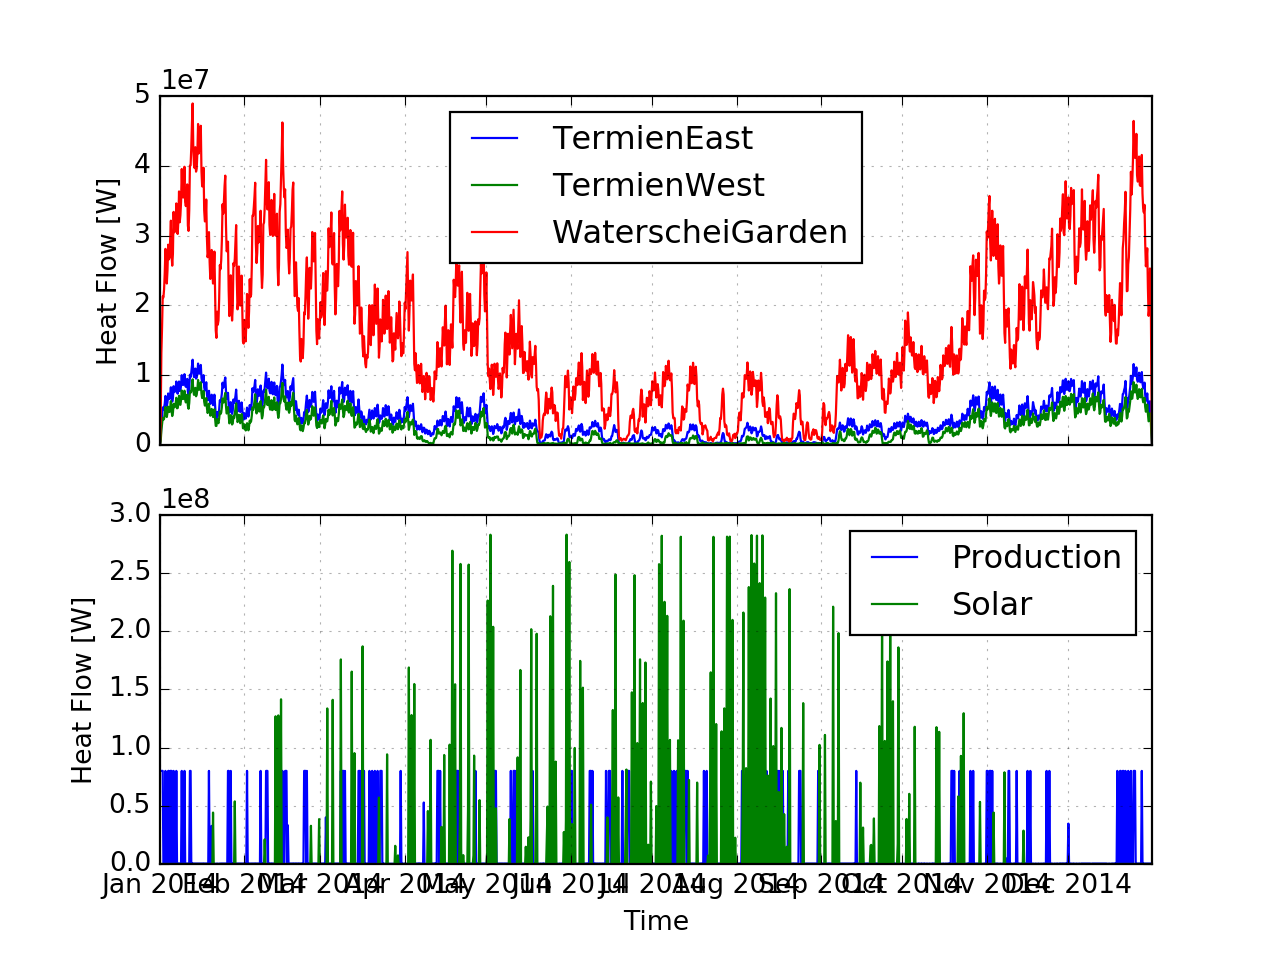

Text(0.5,0,u'Time')

In [27]:
#%matplotlib inline

fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(heat_flows)
ax[0].set_ylabel('Heat Flow [W]')
ax[0].legend(heat_flows.columns, loc='best')

ax[1].plot(inputs)
ax[1].set_ylabel('Heat Flow [W]')
ax[1].legend(inputs.columns, loc='best')

for a in ax:
    a.grid(linewidth=0.5, alpha=0.3)

ax[-1].set_xlabel('Time')

<IPython.core.display.Javascript object>


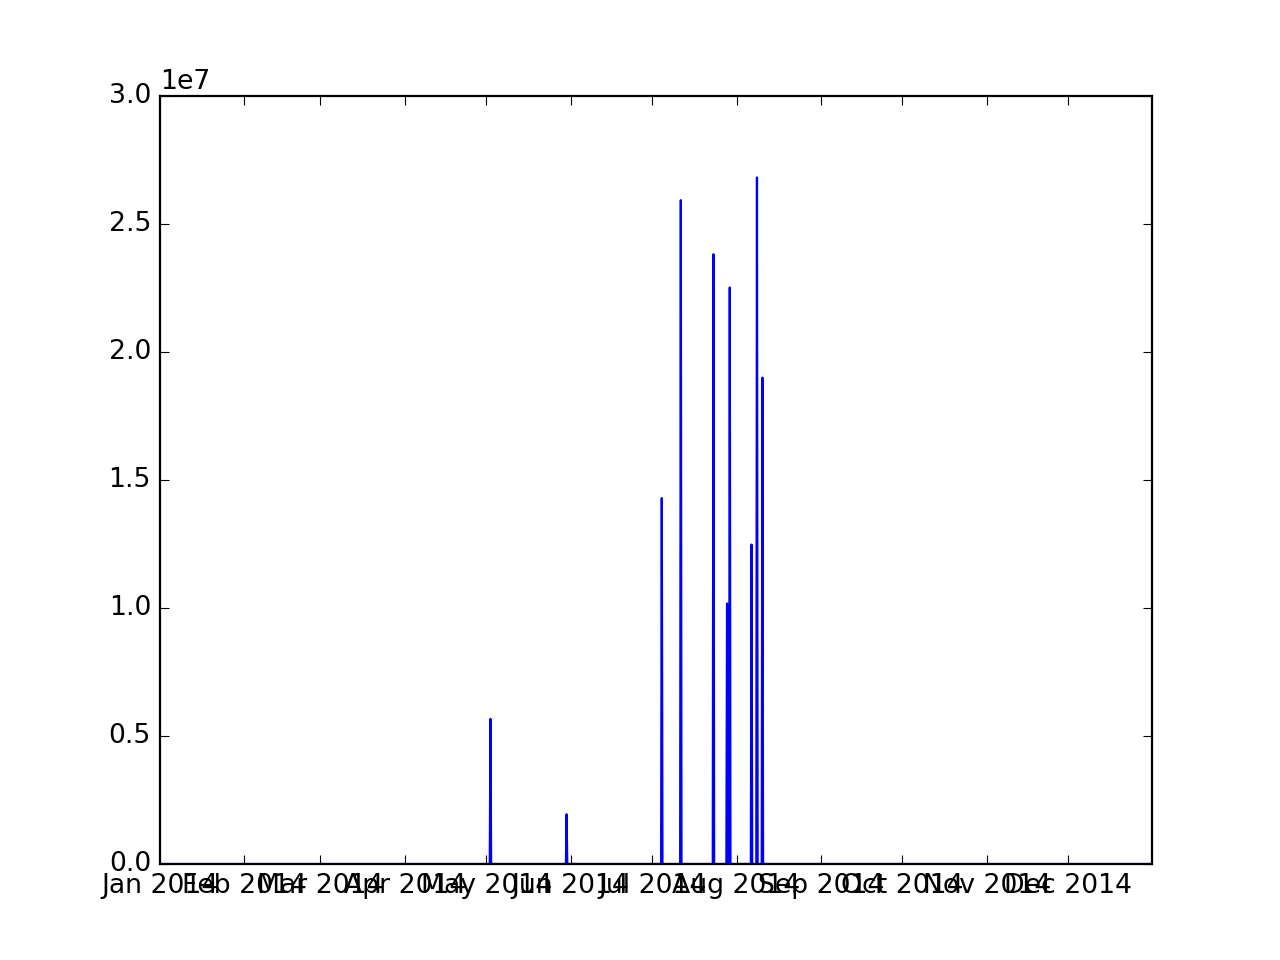

In [44]:
fig, ax = plt.subplots(1,1)
df = optmodel.get_result('heat_flow_curt', node='SolarArray', comp='solar')
ax.plot(df)

## Efficiency check

In [50]:
# Sum of heat flows
prod_e = sum(inputs['Production'])
prod_s = sum(inputs['Solar'])
waterschei_e = sum(heat_flows['WaterscheiGarden'])
termieneast_e = sum(heat_flows['TermienEast'])
termienwest_e = sum(heat_flows['TermienWest'])

# Efficiency
print '\nNetwork efficiency', (termieneast_e + waterschei_e + termienwest_e) / (prod_e + prod_s) * 100, '%'
    


Network efficiency 97.8394082544 %


In [51]:
print sum(optmodel.get_result('heat_flow_max', node='SolarArray', comp='solar'))*200000
print sum(optmodel.get_result('heat_flow', node='SolarArray', comp='solar'))   

4091012430.57
20292419937.4


## Check operation of pipes

<IPython.core.display.Javascript object>


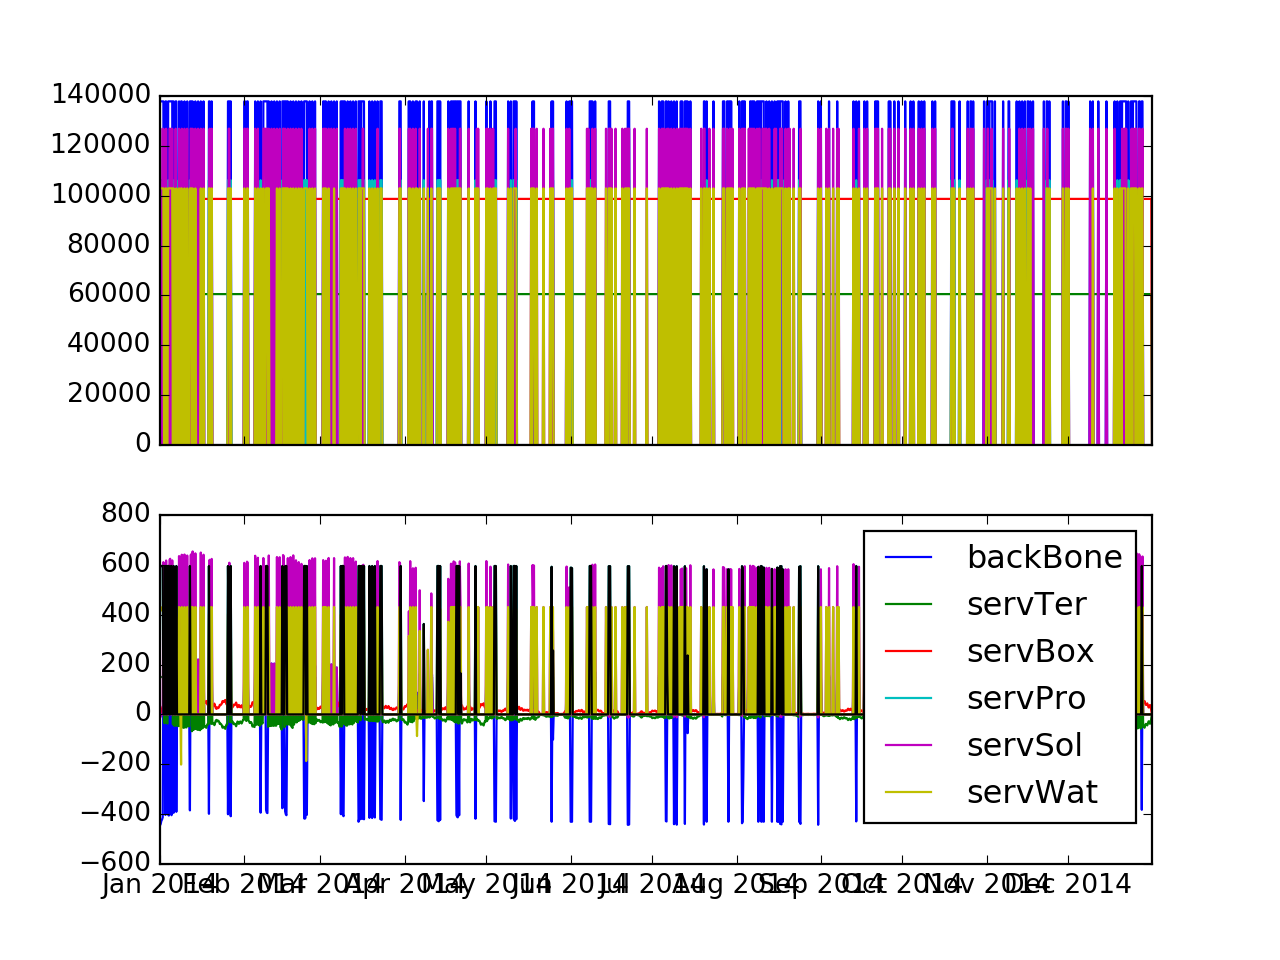

backBone
servTer
servBox
servPro
servSol
servWat


In [52]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, sharex=True)
for pipe in ['backBone', 'servTer', 'servBox', 'servPro', 'servSol', 'servWat']:
    print pipe
    axs[0].plot(optmodel.get_result('heat_loss_tot', comp=pipe), label=pipe)
    axs[1].plot(optmodel.get_result('mass_flow', comp=pipe), label=pipe)
plt.legend()

In [30]:
for pipe in ['backBone', 'servTer', 'servBox', 'servPro', 'servSol', 'servWat']:
    print pipe, str(round(sum(optmodel.get_result('heat_loss_tot', comp=pipe))/1e6,2)), 'MWh'

backBone 1207.51 MWh
servTer 530.45 MWh
servBox 864.9 MWh
servPro 930.55 MWh
servSol 1111.41 MWh
servWat 901.79 MWh


* backBone -1049.81 MWh
* servTer 316.37 MWh
* servBox -515.85 MWh
* servPro 823.69 MWh
* servSol 80.02 MWh
* servWat 899.83 MWh

In [53]:
mass_flows = pd.DataFrame()

mass_flows['Production'] = optmodel.get_result('mass_flow', node='Production', comp='backup')

In [54]:
plt.plot(mass_flows)

<IPython.core.display.Javascript object>


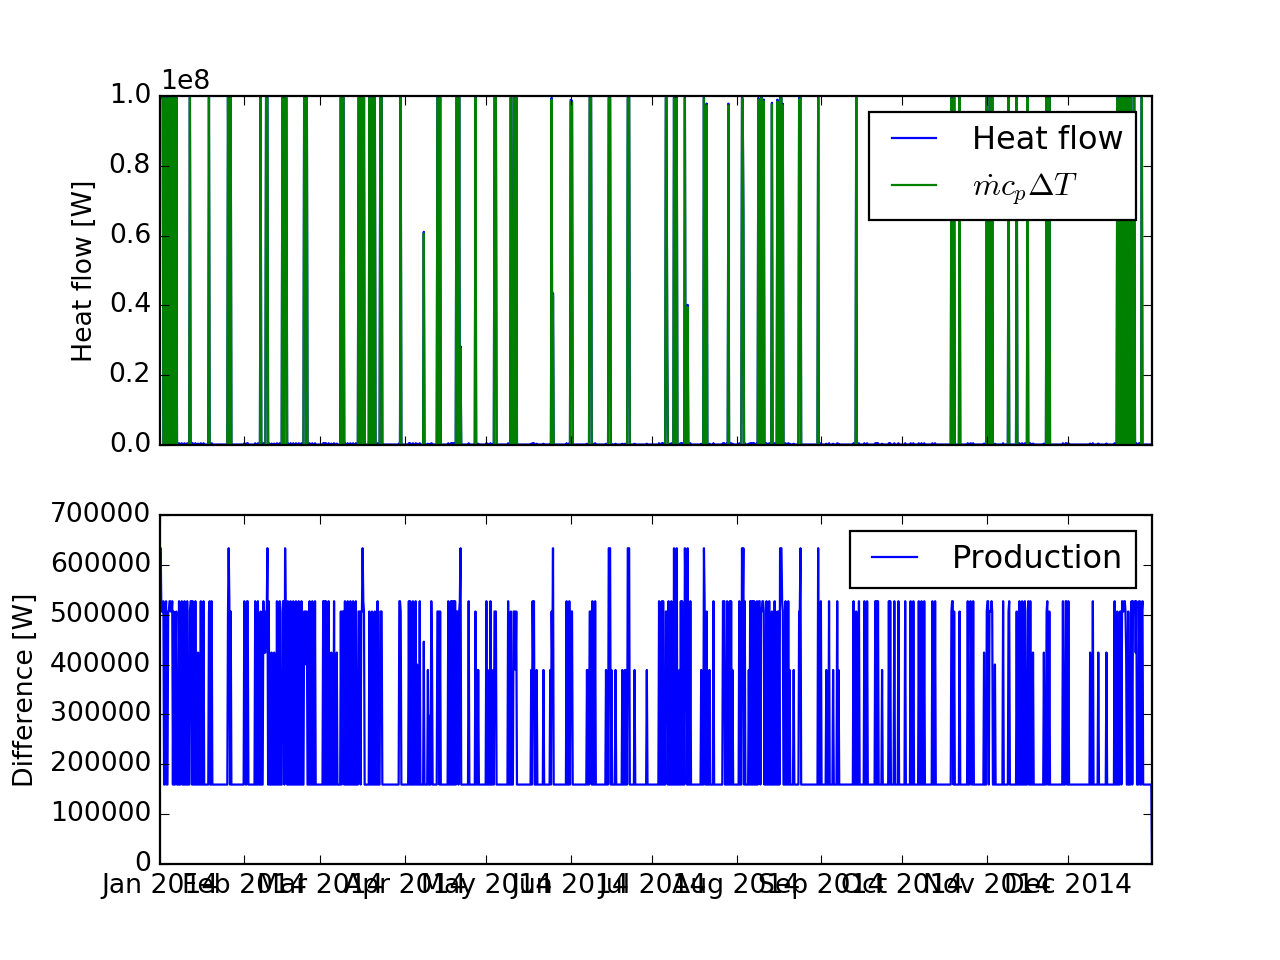

In [55]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(inputs['Production'], label='Heat flow')
axs[0].plot(mass_flows['Production']*40*4180, label='$\dot{m}c_p\Delta T$')
axs[0].legend()

axs[0].set_ylabel('Heat flow [W]')

axs[1].plot(inputs['Production'] - mass_flows['Production']*40*4180)
axs[1].set_ylabel('Difference [W]')

for ax in axs:
    ax.legend()

<IPython.core.display.Javascript object>


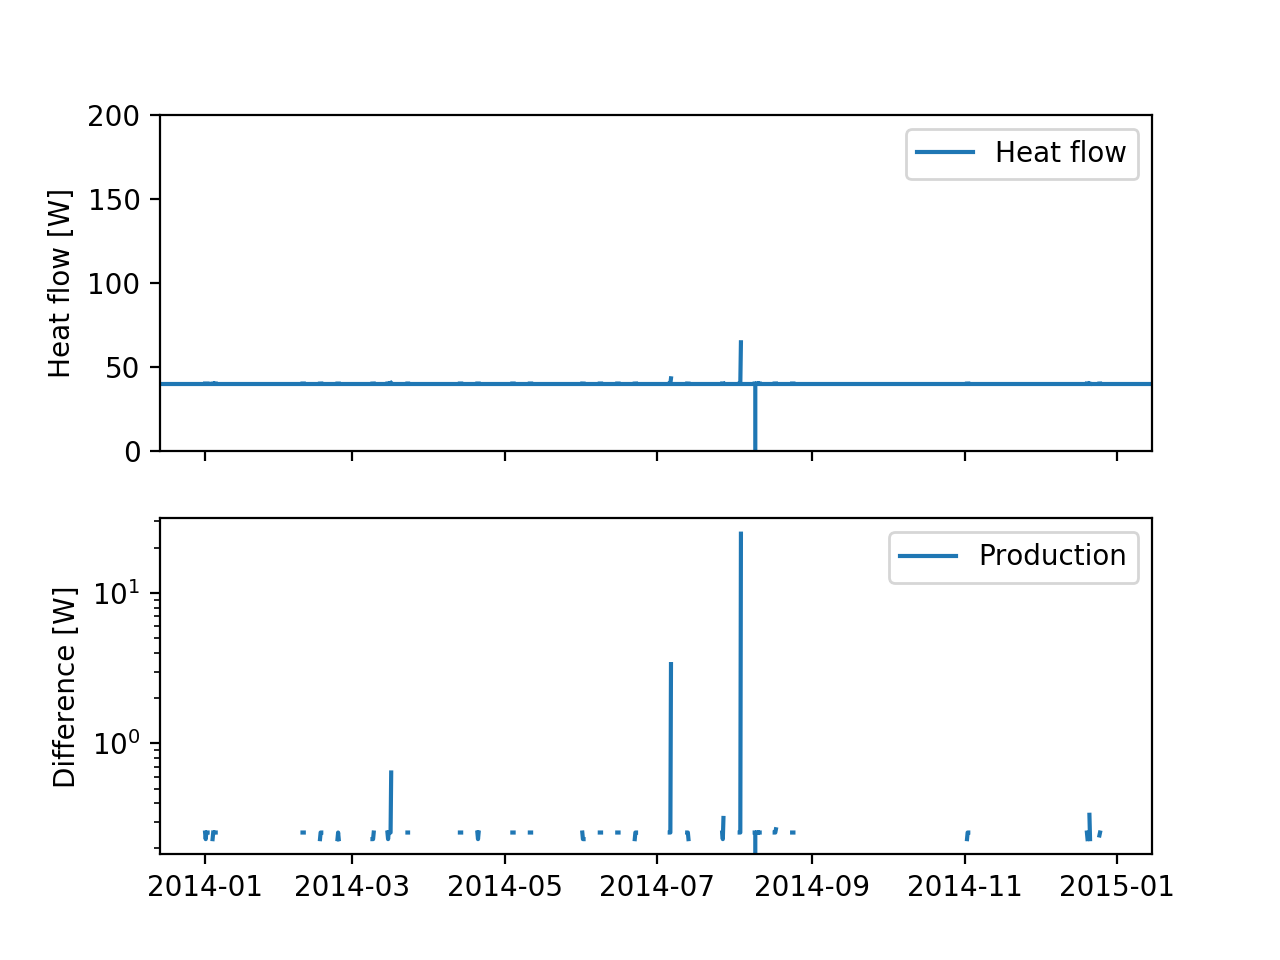

In [34]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(inputs['Production']/(mass_flows['Production']*4180), label='Heat flow')
axs[0].axhline(40)
axs[0].set_ylim(0,200)

axs[0].set_ylabel('Heat flow [W]')

axs[1].semilogy(inputs['Production']/(mass_flows['Production']*4180) - 40)
axs[1].set_ylabel('Difference [W]')

for ax in axs:
    ax.legend()

In [56]:
stor = pd.DataFrame()
soc = pd.DataFrame()

for node in ['SolarArray', 'TermienWest', 'WaterscheiGarden']:
    stor[node] = optmodel.get_result('heat_stor', state=True, node=node, comp='tank')
    soc[node] = optmodel.get_result('soc', state=True, node=node, comp='tank')    

<IPython.core.display.Javascript object>


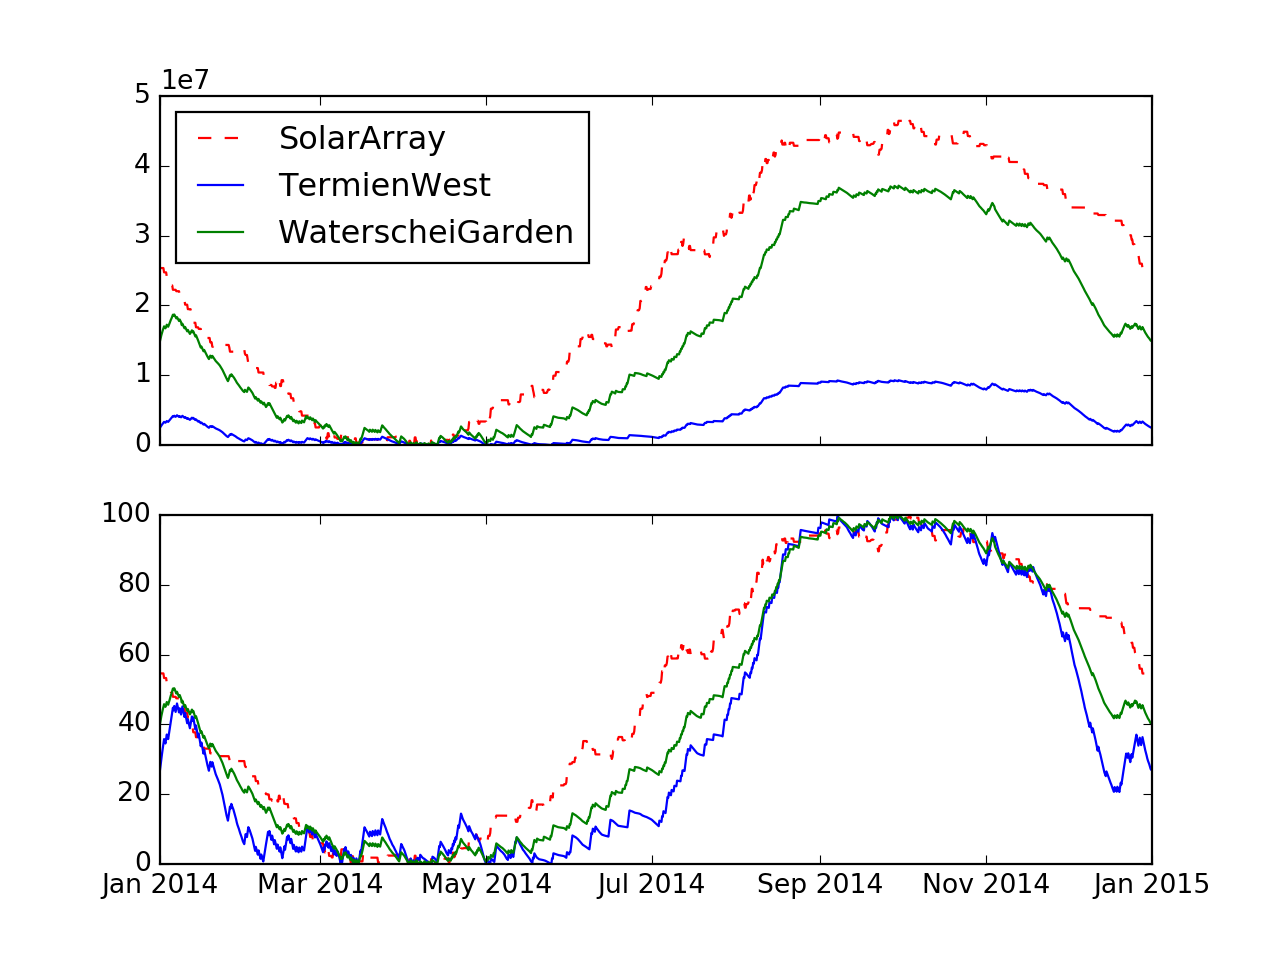

In [57]:
%matplotlib notebook
fig, axs = plt.subplots(2, 1, sharex=True)

ls = {
    'SolarArray': 'r--',
    'TermienWest': 'b',
    'WaterscheiGarden': 'g'
}

for node in stor:
    axs[0].plot(stor[node], ls[node], label=node)
    axs[1].plot(soc[node], ls[node])
    
axs[0].legend(loc='best')